In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch import tensor

import torchaudio
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import numpy as np

import librosa

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/sound classification

/content/drive/MyDrive/Colab Notebooks/sound classification


In [2]:
# 定义一个自定义数据集类
class AudioDataset(Dataset):
    def __init__(self, file_list, label_list):
        self.file_list = file_list
        self.label_list = label_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = self.label_list[idx]

        # 使用 Librosa 加载音频文件，并将其转换为梅尔频谱图
        y, sr = librosa.load(file_path, sr=16000)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=80)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = np.expand_dims(mel_spec_db, axis=0)

        # 返回梅尔频谱图和标签
        return mel_spec_db, label


In [3]:
idx_to_label = "Red-billed Starling,Intermediate Egret,Blue-and-white Flycatcher,Pin-tailed Snipe,Eastern Marsh-Harrier,Manchurian Reed Warbler,Chinese Pond-Heron,Rock Bunting,Isabelline Shrike,Japanese Scops-Owl,Red-backed Shrike,Bronzed Drongo,Claudia's Leaf Warbler,Common Myna,Koklass Pheasant,Barred Warbler,Besra,Pallid Harrier,Tickell's Leaf Warbler,Gray-cheeked Warbler".split(',')

NUM_CLASSES = len(idx_to_label)

label_to_idx = {idx_to_label[i]: i for i in range(NUM_CLASSES)}

train_data_path = 'data/train'

label_to_idx = {value: key for key, value in label_to_idx.items()}

In [4]:
train_files=[]
train_labels =[]
for label in label_to_idx:
        label_dir = f'{train_data_path}/{label}'
        for wav_file in tqdm(os.listdir(label_dir)):
            train_files.append(label_dir + f'/{wav_file}')
            train_labels.append(label)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<?, ?it/s]


In [5]:
from sklearn.model_selection import train_test_split
'''
(1)random_state不填或者为0时，每次都不同；其余值表示不同随机数
(2)shuffle表示是否在分割之前对数据进行洗牌（默认True）
'''
train_f, test_f, train_l, test_l = train_test_split(train_files, train_labels, test_size=0.20,random_state=42,shuffle=True)


In [6]:
train_dataset = AudioDataset(train_f, train_l)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_dataset = AudioDataset(test_f, test_l)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


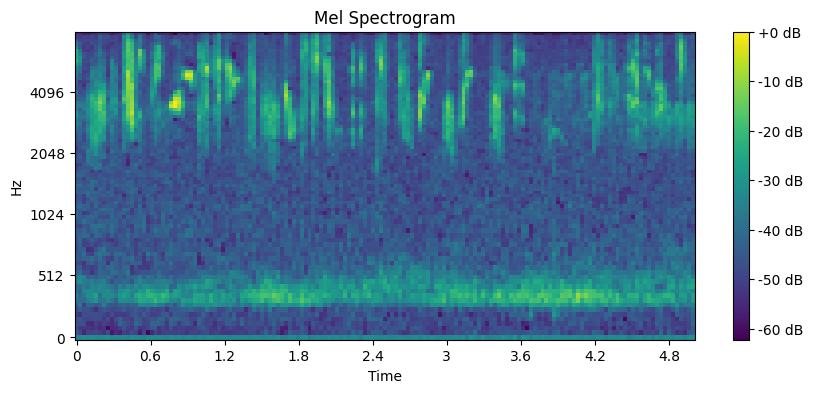

In [ ]:
#可视化
import librosa.display
import matplotlib.pyplot as plt
file_path = train_f[3]
y, sr = librosa.load(file_path, sr=16000)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=512, n_mels=80)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00


In [10]:
import torch.optim as optim
# Load model directly
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

extractor = AutoFeatureExtractor.from_pretrained("WinKawaks/vit-tiny-patch16-224")
model = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

SSLError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /WinKawaks/vit-tiny-patch16-224/resolve/main/preprocessor_config.json (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1131)')))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
from sklearn.metrics import f1_score

def test(model):
    loss_list = []
    #sample_num = 0
    acc_num = 0
    f1 = 0

    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)

            #cur_loss = criterion(outputs, labels).cpu()
            # outputs中的每一项均为包含两个位于0和1之间的浮点数的数组，较大浮点数所在位置即为预测值
            pred = outputs.argmax(dim=1, keepdim=True).cpu()  # 将pred转移到CPU上
            labels = labels.cpu()  # 将labels转移到CPU上

            # 统计预测正确的个数
            acc_num += pred.eq(labels.view_as(pred)).sum()
            #print(acc_num)
            # 记录预测的样本数
            #sample_num = sample_num + labels.size()[0]

            # 计算F1分数，注意我们需要将预测和标签转换为NumPy数组
            #f1 += f1_score(labels.numpy(), pred.numpy(), average='micro')

            #loss_list.append(cur_loss)

    # 计算平均F1分数
    #f1 = f1 / len(test_loader)

    print('平均准确率:{}'.format(acc_num / len(test_f)))
    #print('F1 micro 分数为：',f1)
    return acc_num / len(test_f)


In [ ]:
from torchvision.transforms import Resize
resize_transform = Resize((224, 224))
def train(epoch):
    min_loss = 0.05
    max_acc = 0
    for i in range(epoch):
        for idx, (inputs, labels) in tqdm(enumerate(train_loader)):
            inputs = resize_transform(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = torch.cat([inputs, inputs, inputs], dim=1)
            #print(inputs.shape)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if idx % 10 == 0:
                print('epoch: {}, loss: {}'.format(i+1, loss.item()))

            if loss < min_loss:
                acc = test(model)
                if(acc>max_acc):
                    max_acc = acc
                    print("save model")
                    # 保存模型语句
                    torch.save(model, 'VIT.pt')
            idx = idx + 1
    print(max_acc)

In [ ]:
train(200)

1it [00:37, 37.38s/it]

epoch: 1, loss: 6.290657997131348


11it [05:18, 28.92s/it]


epoch: 1, loss: 3.1053831577301025


1it [00:03,  3.55s/it]

epoch: 2, loss: 3.148677349090576


11it [00:44,  4.01s/it]


epoch: 2, loss: 3.1574342250823975


1it [00:03,  3.63s/it]

epoch: 3, loss: 2.955171823501587


11it [00:44,  4.02s/it]


epoch: 3, loss: 2.9683034420013428


1it [00:03,  3.61s/it]

epoch: 4, loss: 2.9770216941833496


11it [00:44,  4.08s/it]


epoch: 4, loss: 3.0258824825286865


1it [00:04,  4.58s/it]

epoch: 5, loss: 2.987717628479004


11it [00:44,  4.02s/it]


epoch: 5, loss: 2.9991393089294434


1it [00:05,  5.57s/it]

epoch: 6, loss: 3.016483783721924


11it [00:45,  4.10s/it]


epoch: 6, loss: 3.064075231552124


1it [00:05,  5.24s/it]

epoch: 7, loss: 2.9233107566833496


11it [00:45,  4.13s/it]


epoch: 7, loss: 2.9518070220947266


1it [00:04,  4.00s/it]

epoch: 8, loss: 2.9440088272094727


11it [00:44,  4.08s/it]


epoch: 8, loss: 2.9238152503967285


1it [00:03,  3.64s/it]

epoch: 9, loss: 3.048394203186035


11it [00:44,  4.04s/it]


epoch: 9, loss: 2.949331283569336


1it [00:03,  3.65s/it]

epoch: 10, loss: 2.8701658248901367


11it [00:45,  4.16s/it]


epoch: 10, loss: 2.9074478149414062


1it [00:03,  3.59s/it]

epoch: 11, loss: 2.914656400680542


11it [00:44,  4.04s/it]


epoch: 11, loss: 3.016357183456421


1it [00:03,  3.51s/it]

epoch: 12, loss: 2.9126176834106445


11it [00:45,  4.10s/it]


epoch: 12, loss: 2.975752830505371


1it [00:03,  3.98s/it]

epoch: 13, loss: 2.983670949935913


11it [00:44,  4.03s/it]


epoch: 13, loss: 2.946429967880249


1it [00:05,  5.63s/it]

epoch: 14, loss: 3.091883659362793


11it [00:45,  4.15s/it]


epoch: 14, loss: 2.898632764816284


1it [00:04,  4.93s/it]

epoch: 15, loss: 2.947277784347534


11it [00:46,  4.23s/it]


epoch: 15, loss: 2.9950480461120605


1it [00:03,  3.58s/it]

epoch: 16, loss: 2.974384069442749


11it [00:43,  3.98s/it]


epoch: 16, loss: 3.0557949542999268


1it [00:03,  3.54s/it]

epoch: 17, loss: 2.9192702770233154


11it [00:44,  4.01s/it]


epoch: 17, loss: 2.930776357650757


1it [00:03,  3.51s/it]

epoch: 18, loss: 2.9773311614990234


11it [00:44,  4.04s/it]


epoch: 18, loss: 2.900052309036255


1it [00:03,  3.53s/it]

epoch: 19, loss: 2.9415009021759033


11it [00:44,  4.02s/it]


epoch: 19, loss: 2.875636339187622


1it [00:03,  3.51s/it]

epoch: 20, loss: 2.9161176681518555


11it [00:43,  3.95s/it]


epoch: 20, loss: 2.9493937492370605


1it [00:03,  3.67s/it]

epoch: 21, loss: 2.8420605659484863


11it [00:43,  3.98s/it]


epoch: 21, loss: 2.9198663234710693


1it [00:03,  3.64s/it]

epoch: 22, loss: 2.9736273288726807


11it [00:44,  4.00s/it]


epoch: 22, loss: 3.0110888481140137


1it [00:03,  3.53s/it]

epoch: 23, loss: 2.9206714630126953


11it [00:44,  4.04s/it]


epoch: 23, loss: 2.9161479473114014


1it [00:04,  4.37s/it]

epoch: 24, loss: 2.9215853214263916


11it [00:44,  4.02s/it]


epoch: 24, loss: 2.9295928478240967


1it [00:05,  5.80s/it]

epoch: 25, loss: 2.9506442546844482


11it [00:44,  4.05s/it]


epoch: 25, loss: 2.956173896789551


1it [00:05,  5.26s/it]

epoch: 26, loss: 2.90181827545166


11it [00:44,  4.07s/it]


epoch: 26, loss: 2.954662561416626


1it [00:04,  4.20s/it]

epoch: 27, loss: 2.8940858840942383


11it [00:45,  4.09s/it]


epoch: 27, loss: 2.9238998889923096


1it [00:03,  3.51s/it]

epoch: 28, loss: 2.961493730545044


11it [00:43,  3.94s/it]


epoch: 28, loss: 2.9241373538970947


1it [00:03,  3.53s/it]

epoch: 29, loss: 2.8449602127075195


11it [00:44,  4.04s/it]


epoch: 29, loss: 2.9318645000457764


1it [00:03,  3.55s/it]

epoch: 30, loss: 2.860046625137329


11it [00:44,  4.05s/it]


epoch: 30, loss: 2.918534278869629


1it [00:03,  3.56s/it]

epoch: 31, loss: 2.8713903427124023


11it [00:43,  3.98s/it]


epoch: 31, loss: 2.8727896213531494


1it [00:03,  3.58s/it]

epoch: 32, loss: 2.8696815967559814


11it [00:43,  3.98s/it]


epoch: 32, loss: 2.8243298530578613


1it [00:03,  3.53s/it]

epoch: 33, loss: 2.901461601257324


11it [00:43,  3.98s/it]


epoch: 33, loss: 2.9800186157226562


1it [00:03,  3.56s/it]

epoch: 34, loss: 2.841517686843872


11it [00:44,  4.04s/it]


epoch: 34, loss: 2.941082239151001


1it [00:03,  3.59s/it]

epoch: 35, loss: 2.9086334705352783


11it [00:44,  4.02s/it]


epoch: 35, loss: 2.867786407470703


1it [00:04,  4.57s/it]

epoch: 36, loss: 2.888970375061035


11it [00:44,  4.01s/it]


epoch: 36, loss: 2.8840839862823486


1it [00:05,  5.72s/it]

epoch: 37, loss: 2.8743133544921875


11it [00:44,  4.07s/it]


epoch: 37, loss: 2.86746883392334


1it [00:05,  5.30s/it]

epoch: 38, loss: 2.838019371032715


11it [00:45,  4.14s/it]


epoch: 38, loss: 2.877962350845337


1it [00:04,  4.24s/it]

epoch: 39, loss: 2.847649574279785


11it [00:45,  4.11s/it]


epoch: 39, loss: 2.913318157196045


1it [00:03,  3.52s/it]

epoch: 40, loss: 2.8417954444885254


11it [00:44,  4.00s/it]


epoch: 40, loss: 2.9725351333618164


1it [00:03,  3.57s/it]

epoch: 41, loss: 2.809769630432129


11it [00:43,  3.95s/it]


epoch: 41, loss: 2.8914542198181152


1it [00:03,  3.47s/it]

epoch: 42, loss: 2.835453510284424


11it [00:44,  4.06s/it]


epoch: 42, loss: 2.9703516960144043


1it [00:03,  3.57s/it]

epoch: 43, loss: 2.8943612575531006


11it [00:43,  3.97s/it]


epoch: 43, loss: 2.874081611633301


1it [00:03,  3.47s/it]

epoch: 44, loss: 2.7903823852539062


11it [00:44,  4.04s/it]


epoch: 44, loss: 2.8058547973632812


1it [00:03,  3.55s/it]

epoch: 45, loss: 2.7936816215515137


11it [00:45,  4.10s/it]


epoch: 45, loss: 2.9913790225982666


1it [00:03,  3.92s/it]

epoch: 46, loss: 2.798983097076416


11it [00:43,  3.98s/it]


epoch: 46, loss: 2.879307985305786


1it [00:04,  4.48s/it]

epoch: 47, loss: 2.824138879776001


11it [00:43,  3.98s/it]


epoch: 47, loss: 2.8340721130371094


1it [00:05,  5.78s/it]

epoch: 48, loss: 2.7326924800872803


11it [00:45,  4.17s/it]


epoch: 48, loss: 2.9657368659973145


1it [00:04,  4.59s/it]

epoch: 49, loss: 2.726437568664551


11it [00:46,  4.18s/it]


epoch: 49, loss: 2.9808199405670166


1it [00:03,  3.55s/it]

epoch: 50, loss: 2.8385283946990967


11it [00:44,  4.08s/it]


epoch: 50, loss: 2.7661359310150146


1it [00:03,  3.64s/it]

epoch: 51, loss: 2.731727361679077


11it [00:44,  4.02s/it]


epoch: 51, loss: 2.8968920707702637


1it [00:03,  3.62s/it]

epoch: 52, loss: 2.856886625289917


11it [00:44,  4.00s/it]


epoch: 52, loss: 2.8466248512268066


1it [00:03,  3.54s/it]

epoch: 53, loss: 2.810197114944458


11it [00:43,  3.99s/it]


epoch: 53, loss: 2.795372486114502


1it [00:03,  3.47s/it]

epoch: 54, loss: 2.798673391342163


11it [00:44,  4.05s/it]


epoch: 54, loss: 2.7936670780181885


1it [00:03,  3.73s/it]

epoch: 55, loss: 2.8691720962524414


11it [00:44,  4.01s/it]


epoch: 55, loss: 2.821845769882202


1it [00:05,  5.15s/it]

epoch: 56, loss: 2.6412429809570312


11it [00:44,  4.00s/it]


epoch: 56, loss: 2.8362550735473633


1it [00:05,  5.75s/it]

epoch: 57, loss: 2.712982416152954


11it [00:45,  4.14s/it]


epoch: 57, loss: 2.779877185821533


1it [00:04,  4.48s/it]

epoch: 58, loss: 2.752882719039917


11it [00:45,  4.16s/it]


epoch: 58, loss: 2.7505104541778564


1it [00:03,  3.56s/it]

epoch: 59, loss: 2.863863468170166


11it [00:44,  4.02s/it]


epoch: 59, loss: 2.7014644145965576


1it [00:03,  3.51s/it]

epoch: 60, loss: 2.759114980697632


11it [00:44,  4.00s/it]


epoch: 60, loss: 2.7307443618774414


1it [00:03,  3.51s/it]

epoch: 61, loss: 2.81648588180542


11it [00:44,  4.03s/it]


epoch: 61, loss: 2.751511573791504


1it [00:03,  3.55s/it]

epoch: 62, loss: 2.7896695137023926


11it [00:44,  4.02s/it]


epoch: 62, loss: 2.8561978340148926


1it [00:03,  3.55s/it]

epoch: 63, loss: 2.8924503326416016


11it [00:44,  4.03s/it]


epoch: 63, loss: 2.796849489212036


1it [00:03,  3.55s/it]

epoch: 64, loss: 2.834275484085083


11it [00:43,  3.98s/it]


epoch: 64, loss: 2.778160333633423


1it [00:04,  4.13s/it]

epoch: 65, loss: 2.7938590049743652


11it [00:44,  4.04s/it]


epoch: 65, loss: 2.9397528171539307


1it [00:05,  5.31s/it]

epoch: 66, loss: 2.620723009109497


11it [00:44,  4.00s/it]


epoch: 66, loss: 2.834672212600708


1it [00:05,  5.48s/it]

epoch: 67, loss: 2.7254669666290283


11it [00:44,  4.09s/it]


epoch: 67, loss: 2.7472221851348877


1it [00:04,  4.53s/it]

epoch: 68, loss: 2.640662431716919


11it [00:45,  4.16s/it]


epoch: 68, loss: 2.7152106761932373


1it [00:03,  3.50s/it]

epoch: 69, loss: 2.7336130142211914


11it [00:43,  3.98s/it]


epoch: 69, loss: 2.7684314250946045


1it [00:03,  3.55s/it]

epoch: 70, loss: 2.6828808784484863


11it [00:44,  4.05s/it]


epoch: 70, loss: 2.6925249099731445


1it [00:03,  3.57s/it]

epoch: 71, loss: 2.730450391769409


11it [00:45,  4.11s/it]


epoch: 71, loss: 2.582566499710083


1it [00:03,  3.54s/it]

epoch: 72, loss: 2.616619348526001


11it [00:44,  4.00s/it]


epoch: 72, loss: 2.6587557792663574


1it [00:03,  3.55s/it]

epoch: 73, loss: 2.7101070880889893


11it [00:44,  4.03s/it]


epoch: 73, loss: 2.585129737854004


1it [00:03,  3.68s/it]

epoch: 74, loss: 2.5876569747924805


11it [00:43,  3.99s/it]


epoch: 74, loss: 2.618734359741211


1it [00:04,  4.20s/it]

epoch: 75, loss: 2.5812461376190186


11it [00:44,  4.07s/it]


epoch: 75, loss: 2.4250590801239014


1it [00:05,  5.93s/it]

epoch: 76, loss: 2.616471290588379


11it [00:45,  4.15s/it]


epoch: 76, loss: 2.762146234512329


1it [00:04,  4.93s/it]

epoch: 77, loss: 2.713028907775879


11it [00:45,  4.14s/it]


epoch: 77, loss: 2.6736643314361572


1it [00:03,  3.83s/it]

epoch: 78, loss: 2.4758307933807373


11it [00:44,  4.06s/it]


epoch: 78, loss: 2.6185336112976074


1it [00:03,  3.72s/it]

epoch: 79, loss: 2.512795925140381


11it [00:44,  4.03s/it]


epoch: 79, loss: 2.688877582550049


1it [00:03,  3.68s/it]

epoch: 80, loss: 2.4740729331970215


11it [00:44,  4.08s/it]


epoch: 80, loss: 2.452781915664673


1it [00:03,  3.62s/it]

epoch: 81, loss: 2.548927068710327


11it [00:43,  3.98s/it]


epoch: 81, loss: 2.420102119445801


1it [00:03,  3.52s/it]

epoch: 82, loss: 2.519768476486206


11it [00:44,  4.00s/it]


epoch: 82, loss: 2.5649073123931885


1it [00:03,  3.54s/it]

epoch: 83, loss: 2.458584785461426


11it [00:43,  3.99s/it]


epoch: 83, loss: 2.3396124839782715


1it [00:03,  3.57s/it]

epoch: 84, loss: 2.5338306427001953


11it [00:43,  3.99s/it]


epoch: 84, loss: 2.6341264247894287


1it [00:04,  4.24s/it]

epoch: 85, loss: 2.3490335941314697


11it [00:44,  4.05s/it]


epoch: 85, loss: 2.5048141479492188


1it [00:05,  5.66s/it]

epoch: 86, loss: 2.379293203353882


11it [00:45,  4.11s/it]


epoch: 86, loss: 2.5725860595703125


1it [00:04,  4.58s/it]

epoch: 87, loss: 2.4612505435943604


11it [00:44,  4.01s/it]


epoch: 87, loss: 2.3475022315979004


1it [00:04,  4.14s/it]

epoch: 88, loss: 2.399280309677124


11it [00:44,  4.09s/it]


epoch: 88, loss: 2.5690910816192627


1it [00:03,  3.54s/it]

epoch: 89, loss: 2.413522481918335


11it [00:44,  4.04s/it]


epoch: 89, loss: 3.5624098777770996


1it [00:03,  3.56s/it]

epoch: 90, loss: 2.485222339630127


11it [00:44,  4.01s/it]


epoch: 90, loss: 2.808856725692749


1it [00:03,  3.83s/it]

epoch: 91, loss: 2.8216986656188965


11it [00:44,  4.04s/it]


epoch: 91, loss: 2.6329703330993652


1it [00:03,  3.54s/it]

epoch: 92, loss: 2.757418155670166


11it [00:44,  4.06s/it]


epoch: 92, loss: 2.7029833793640137


1it [00:03,  3.42s/it]

epoch: 93, loss: 2.751504421234131


11it [00:44,  4.03s/it]


epoch: 93, loss: 2.6247172355651855


1it [00:03,  3.59s/it]

epoch: 94, loss: 2.42707896232605


11it [00:44,  4.01s/it]


epoch: 94, loss: 2.5735461711883545


1it [00:04,  4.42s/it]

epoch: 95, loss: 2.3421595096588135


11it [00:44,  4.02s/it]


epoch: 95, loss: 2.2953860759735107


1it [00:05,  5.51s/it]

epoch: 96, loss: 2.3549458980560303


11it [00:44,  4.02s/it]


epoch: 96, loss: 2.3376717567443848


1it [00:05,  5.63s/it]

epoch: 97, loss: 2.465416193008423


11it [00:45,  4.10s/it]


epoch: 97, loss: 2.2863433361053467


1it [00:04,  4.52s/it]

epoch: 98, loss: 2.388228416442871


11it [00:45,  4.14s/it]


epoch: 98, loss: 2.526256799697876


1it [00:03,  3.59s/it]

epoch: 99, loss: 2.2359917163848877


11it [00:43,  3.96s/it]


epoch: 99, loss: 2.3367936611175537


1it [00:03,  3.67s/it]

epoch: 100, loss: 2.0849850177764893


11it [00:43,  3.95s/it]


epoch: 100, loss: 2.1246469020843506


1it [00:03,  3.51s/it]

epoch: 101, loss: 2.163001298904419


11it [00:43,  3.95s/it]


epoch: 101, loss: 2.038113594055176


1it [00:03,  3.46s/it]

epoch: 102, loss: 2.3107826709747314


11it [00:43,  3.94s/it]


epoch: 102, loss: 2.3169522285461426


1it [00:03,  3.53s/it]

epoch: 103, loss: 2.531932830810547


11it [00:44,  4.02s/it]


epoch: 103, loss: 2.3099281787872314


1it [00:03,  3.53s/it]

epoch: 104, loss: 2.058236598968506


11it [00:43,  3.95s/it]


epoch: 104, loss: 2.2032172679901123


1it [00:03,  3.60s/it]

epoch: 105, loss: 2.2053475379943848


11it [00:44,  4.00s/it]


epoch: 105, loss: 2.289107322692871


1it [00:03,  3.53s/it]

epoch: 106, loss: 2.1850545406341553


11it [00:44,  4.02s/it]


epoch: 106, loss: 2.353935956954956


1it [00:03,  3.61s/it]

epoch: 107, loss: 2.1031413078308105


11it [00:43,  3.97s/it]


epoch: 107, loss: 2.196758508682251


1it [00:03,  3.87s/it]

epoch: 108, loss: 2.1580591201782227


11it [00:43,  3.93s/it]


epoch: 108, loss: 2.3558349609375


1it [00:04,  4.54s/it]

epoch: 109, loss: 2.194732904434204


11it [00:43,  3.98s/it]


epoch: 109, loss: 2.2660281658172607


1it [00:04,  4.84s/it]

epoch: 110, loss: 2.109503746032715


11it [00:43,  3.95s/it]


epoch: 110, loss: 2.116436719894409


1it [00:04,  4.99s/it]

epoch: 111, loss: 1.9467130899429321


11it [00:43,  3.94s/it]


epoch: 111, loss: 2.4231746196746826


1it [00:05,  5.13s/it]

epoch: 112, loss: 2.24401593208313


11it [00:43,  3.95s/it]


epoch: 112, loss: 2.198627233505249


1it [00:05,  5.57s/it]

epoch: 113, loss: 1.9629708528518677


11it [00:43,  3.94s/it]


epoch: 113, loss: 2.112283229827881


1it [00:05,  5.52s/it]

epoch: 114, loss: 2.1632251739501953


11it [00:44,  4.03s/it]


epoch: 114, loss: 2.160454273223877


1it [00:04,  4.93s/it]

epoch: 115, loss: 2.1326920986175537


11it [00:43,  3.98s/it]


epoch: 115, loss: 2.223536252975464


1it [00:04,  4.40s/it]

epoch: 116, loss: 2.0586330890655518


11it [00:43,  3.98s/it]


epoch: 116, loss: 1.9408855438232422


1it [00:04,  4.31s/it]

epoch: 117, loss: 2.1579394340515137


11it [00:43,  4.00s/it]


epoch: 117, loss: 2.081221342086792


1it [00:03,  3.70s/it]

epoch: 118, loss: 2.0501086711883545


11it [00:43,  3.92s/it]


epoch: 118, loss: 2.2503342628479004


1it [00:03,  3.69s/it]

epoch: 119, loss: 2.1311323642730713


11it [00:43,  3.99s/it]


epoch: 119, loss: 2.1074137687683105


1it [00:03,  3.47s/it]

epoch: 120, loss: 1.9380464553833008


11it [00:43,  3.94s/it]


epoch: 120, loss: 1.897392749786377


1it [00:03,  3.47s/it]

epoch: 121, loss: 1.9537380933761597


11it [00:44,  4.00s/it]


epoch: 121, loss: 2.1857502460479736


1it [00:03,  3.54s/it]

epoch: 122, loss: 1.9669885635375977


11it [00:43,  3.92s/it]


epoch: 122, loss: 1.9246115684509277


1it [00:03,  3.53s/it]

epoch: 123, loss: 2.077664375305176


11it [00:43,  3.94s/it]


epoch: 123, loss: 2.0644631385803223


1it [00:03,  3.54s/it]

epoch: 124, loss: 1.972917079925537


11it [00:42,  3.91s/it]


epoch: 124, loss: 1.97310209274292


1it [00:03,  3.50s/it]

epoch: 125, loss: 1.9067119359970093


11it [00:43,  3.92s/it]


epoch: 125, loss: 1.9890415668487549


1it [00:03,  3.57s/it]

epoch: 126, loss: 1.7904295921325684


11it [00:44,  4.03s/it]


epoch: 126, loss: 2.032134771347046


1it [00:03,  3.47s/it]

epoch: 127, loss: 1.8923132419586182


11it [00:43,  3.96s/it]


epoch: 127, loss: 1.9901283979415894


1it [00:03,  3.39s/it]

epoch: 128, loss: 1.950119137763977


11it [00:43,  3.93s/it]


epoch: 128, loss: 1.9593719244003296


1it [00:03,  3.51s/it]

epoch: 129, loss: 1.8462780714035034


11it [00:43,  3.94s/it]


epoch: 129, loss: 1.8690698146820068


1it [00:03,  3.49s/it]

epoch: 130, loss: 1.8801753520965576


11it [00:43,  3.94s/it]


epoch: 130, loss: 2.108877182006836


1it [00:03,  3.45s/it]

epoch: 131, loss: 2.041465997695923


11it [00:43,  3.96s/it]


epoch: 131, loss: 1.9297455549240112


1it [00:03,  3.55s/it]

epoch: 132, loss: 2.0127224922180176


11it [00:43,  3.91s/it]


epoch: 132, loss: 1.8516933917999268


1it [00:03,  3.52s/it]

epoch: 133, loss: 1.6425095796585083


11it [00:43,  3.97s/it]


epoch: 133, loss: 1.7733262777328491


1it [00:03,  3.50s/it]

epoch: 134, loss: 1.7667796611785889


11it [00:43,  3.95s/it]


epoch: 134, loss: 1.903607964515686


1it [00:03,  3.66s/it]

epoch: 135, loss: 1.6994209289550781


11it [00:42,  3.90s/it]


epoch: 135, loss: 1.7438421249389648


1it [00:04,  4.22s/it]

epoch: 136, loss: 1.7668075561523438


11it [00:43,  3.95s/it]


epoch: 136, loss: 1.5967873334884644


1it [00:03,  3.86s/it]

epoch: 137, loss: 1.6489273309707642


11it [00:43,  3.93s/it]


epoch: 137, loss: 1.773929476737976


1it [00:04,  4.76s/it]

epoch: 138, loss: 1.8137866258621216


11it [00:43,  3.94s/it]


epoch: 138, loss: 1.6365818977355957


1it [00:05,  5.41s/it]

epoch: 139, loss: 1.367458462715149


11it [00:43,  3.92s/it]


epoch: 139, loss: 1.5762674808502197


1it [00:05,  5.67s/it]

epoch: 140, loss: 1.5284708738327026


11it [00:43,  3.99s/it]


epoch: 140, loss: 1.904524564743042


1it [00:05,  5.20s/it]

epoch: 141, loss: 1.6432591676712036


11it [00:44,  4.02s/it]


epoch: 141, loss: 2.1562488079071045


1it [00:04,  4.52s/it]

epoch: 142, loss: 2.281897783279419


11it [00:43,  3.98s/it]


epoch: 142, loss: 1.7487539052963257


1it [00:04,  4.04s/it]

epoch: 143, loss: 1.8346110582351685


11it [00:44,  4.01s/it]


epoch: 143, loss: 1.8740304708480835


1it [00:03,  3.53s/it]

epoch: 144, loss: 1.7062463760375977


11it [00:43,  4.00s/it]


epoch: 144, loss: 1.685158371925354


1it [00:03,  3.57s/it]

epoch: 145, loss: 1.797004222869873


11it [00:43,  3.97s/it]


epoch: 145, loss: 1.5618799924850464


1it [00:03,  3.56s/it]

epoch: 146, loss: 1.3962920904159546


11it [00:43,  3.93s/it]


epoch: 146, loss: 1.5382906198501587


1it [00:03,  3.47s/it]

epoch: 147, loss: 1.2903060913085938


11it [00:44,  4.04s/it]


epoch: 147, loss: 1.36528480052948


1it [00:03,  3.46s/it]

epoch: 148, loss: 1.3814353942871094


11it [00:43,  3.96s/it]


epoch: 148, loss: 1.3051844835281372


1it [00:03,  3.51s/it]

epoch: 149, loss: 1.3269151449203491


11it [00:43,  3.94s/it]


epoch: 149, loss: 1.175660490989685


1it [00:03,  3.46s/it]

epoch: 150, loss: 1.0836317539215088


11it [00:43,  3.94s/it]


epoch: 150, loss: 1.2965137958526611


1it [00:03,  3.52s/it]

epoch: 151, loss: 1.139804482460022


11it [00:43,  3.97s/it]


epoch: 151, loss: 1.3869072198867798


1it [00:03,  3.78s/it]

epoch: 152, loss: 1.174833059310913


11it [00:43,  3.97s/it]


epoch: 152, loss: 1.3785033226013184


1it [00:03,  3.51s/it]

epoch: 153, loss: 1.1794283390045166


11it [00:44,  4.02s/it]


epoch: 153, loss: 1.1970926523208618


1it [00:03,  3.57s/it]

epoch: 154, loss: 0.880318284034729


11it [00:43,  3.98s/it]


epoch: 154, loss: 1.2097997665405273


1it [00:04,  4.18s/it]

epoch: 155, loss: 1.0206774473190308


11it [00:44,  4.00s/it]


epoch: 155, loss: 1.1056846380233765


1it [00:04,  4.82s/it]

epoch: 156, loss: 0.833824872970581


11it [00:43,  3.99s/it]


epoch: 156, loss: 1.0060547590255737


1it [00:06,  6.08s/it]

epoch: 157, loss: 0.8518036603927612


11it [00:44,  4.05s/it]


epoch: 157, loss: 0.6984473466873169


1it [00:05,  5.16s/it]

epoch: 158, loss: 0.6042031645774841


11it [00:44,  4.08s/it]


epoch: 158, loss: 1.0995326042175293


1it [00:04,  4.08s/it]

epoch: 159, loss: 0.750626802444458


11it [00:44,  4.09s/it]


epoch: 159, loss: 0.8431825041770935


1it [00:03,  3.53s/it]

epoch: 160, loss: 0.5913941860198975


11it [00:43,  3.99s/it]


epoch: 160, loss: 0.9614199995994568


1it [00:03,  3.64s/it]

epoch: 161, loss: 0.8496910333633423


11it [00:44,  4.05s/it]


epoch: 161, loss: 0.7884224057197571


1it [00:03,  3.59s/it]

epoch: 162, loss: 0.44812729954719543


11it [00:44,  4.00s/it]


epoch: 162, loss: 0.7462119460105896


1it [00:03,  3.57s/it]

epoch: 163, loss: 0.5982444286346436


11it [00:44,  4.02s/it]


epoch: 163, loss: 0.8747502565383911


1it [00:03,  3.51s/it]

epoch: 164, loss: 0.6399901509284973


11it [00:43,  3.97s/it]


epoch: 164, loss: 0.8921166658401489


1it [00:03,  3.62s/it]

epoch: 165, loss: 0.7315732836723328


11it [00:45,  4.12s/it]


epoch: 165, loss: 0.5887561440467834


1it [00:04,  4.53s/it]

epoch: 166, loss: 0.6293917298316956


11it [00:45,  4.14s/it]


epoch: 166, loss: 0.5697709918022156


1it [00:05,  5.74s/it]

epoch: 167, loss: 0.538838267326355


11it [00:47,  4.33s/it]


epoch: 167, loss: 0.5448141694068909


1it [00:03,  3.96s/it]

epoch: 168, loss: 0.6378276944160461


11it [00:45,  4.12s/it]


epoch: 168, loss: 0.8717444539070129


1it [00:03,  3.69s/it]

epoch: 169, loss: 0.6793627142906189


11it [00:44,  4.06s/it]


epoch: 169, loss: 1.0570907592773438


1it [00:03,  3.73s/it]

epoch: 170, loss: 0.7745797038078308


11it [00:44,  4.07s/it]


epoch: 170, loss: 1.033821702003479


1it [00:03,  3.53s/it]

epoch: 171, loss: 0.8090405464172363


In [ ]:
#使数据符合VIT模型
from torchvision.transforms import Resize
resize_transform = Resize((224, 224))
for idx, (inputs, labels) in tqdm(enumerate(train_loader)):
  inputs = resize_transform(inputs)
  inputs = inputs.to(device)
  #labels = labels.to(device)
  inputs = torch.cat([inputs, inputs, inputs], dim=1)
  print(inputs.shape)
  break

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
0it [00:18, ?it/s]

torch.Size([100, 3, 224, 224])
